# Dogs V Cats (data augmentation edition)

Applies data augmentation to the input images and runs for several epochs

In [1]:
%matplotlib inline

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [2]:
root_path = "data/dogscats-redux/"
weights_path = root_path + 'keith_weights_1.h5'

path = root_path
#path = root_path + "sample/"

A few basic libraries that we'll need for the initial exercises:

In [3]:
from __future__ import division,print_function

import os, json, shutil, random, math
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [4]:
import utils; reload(utils)
from utils import plots

Using cuDNN version 5103 on context None
Mapped name None to device cuda: Tesla K80 (9F07:00:00.0)
Using Theano backend.


In [5]:
def predict_and_show(batches):
    imgs, labels = next(batches)
    preds, indexes, predicted_labels = vgg.predict(imgs)
    true_labels = [vgg.classes[idx] for idx in np.argmax(labels, axis=1)]
    plots(imgs, titles=['ok' if a == b else 'wrong' for (a,b) in zip(true_labels, predicted_labels)])

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator()

## Use our Vgg16 class to finetune a Dogs vs Cats model

To change our model so that it outputs "cat" vs "dog", instead of one of 1,000 very specific categories, we need to use a process called "finetuning". Finetuning looks from the outside to be identical to normal machine learning training - we provide a training set with data and labels to learn from, and a validation set to test against. The model learns a set of parameters based on the data provided.

However, the difference is that we start with a model that is already trained to solve a similar problem. The idea is that many of the parameters should be very similar, or the same, between the existing model, and the model we wish to create. Therefore, we only select a subset of parameters to train, and leave the rest untouched. This happens automatically when we call *fit()* after calling *finetune()*.

We create our batches just like before, and making the validation set available as well. A 'batch' (or *mini-batch* as it is commonly known) is simply a subset of the training data - we use a subset at a time when training or predicting, in order to speed up training, and to avoid running out of memory.

In [10]:
batch_size=64

In [11]:
import vgg16; reload(vgg16)

<module 'vgg16' from 'vgg16.py'>

In [12]:
vgg = vgg16.Vgg16()
batches = vgg.get_batches(path+'train', gen=train_datagen, batch_size=batch_size)
validation_batches = vgg.get_batches(path+'validation', gen=test_datagen, batch_size=batch_size)

using vgg16 weights & architecture
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Calling *finetune()* modifies the model such that it will be trained based on the data in the batches provided - in this case, to predict either 'dog' or 'cat'.

In [13]:
vgg.finetune(batches)

Finally, we *fit()* the parameters of the model using the training data, reporting the accuracy on the validation set after every epoch. (An *epoch* is one full pass through the training data.)

In [14]:
hist = vgg.fit(batches, validation_batches, nb_epoch=3)

Epoch 1/3
20000/20000 [==============================] - 1100s - loss: 0.1492 - acc: 0.9602 - val_loss: 0.0574 - val_acc: 0.9832
Epoch 2/3
20000/20000 [==============================] - 499s - loss: 0.1220 - acc: 0.9718 - val_loss: 0.0717 - val_acc: 0.9816
Epoch 3/3
20000/20000 [==============================] - 507s - loss: 0.1129 - acc: 0.9748 - val_loss: 0.0563 - val_acc: 0.9892


In [15]:
def plot_train_validation_curves(title, training_series, validation_series):
    num_epochs = len(training_series)
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, validation_series, label='validation')
    plt.plot(epochs, training_series, label='train')
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

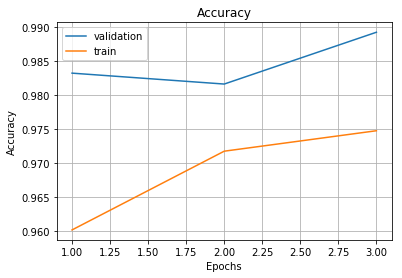

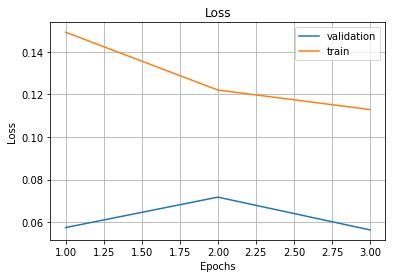

In [16]:
plot_train_validation_curves('Accuracy', hist.history['acc'], hist.history['val_acc'])
plot_train_validation_curves('Loss', hist.history['loss'], hist.history['val_loss'])

# Try it out

In [17]:
dummy_batches = vgg.get_batches(path+'train', batch_size=6)

Found 20000 images belonging to 2 classes.


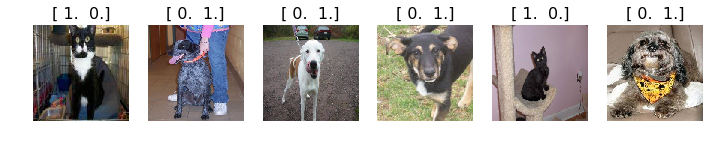

In [18]:
imgs, labels = next(dummy_batches)
plots(imgs, titles=labels)

In [19]:
vgg.predict(imgs)

(array([ 1.    ,  1.    ,  1.    ,  1.    ,  0.9991,  1.    ], dtype=float32),
 array([0, 1, 1, 1, 0, 1]),
 ['cats', 'dogs', 'dogs', 'dogs', 'cats', 'dogs'])

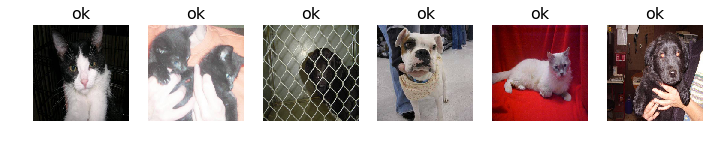

In [20]:
predict_and_show(dummy_batches)

# Kaggle Submission

In [21]:
test_batches = vgg.get_batches(path + 'test', gen=test_datagen, batch_size=32, class_mode=None, shuffle=False)

Found 12500 images belonging to 1 classes.


In [22]:
dog_predictions = vgg.model.predict_generator(test_batches, test_batches.nb_sample)[:,1]
dog_predictions[:5]

array([  4.5670e-06,   1.0000e+00,   4.5467e-08,   9.9978e-01,   9.9282e-01], dtype=float32)

Extract the id of each image in the test batch because Keras ImageDataGenerator will enumerate them in lexical order

In [23]:
ids = [int(x.split("/")[1].split(".")[0]) for x in test_batches.filenames]
ids[:5]

[10792, 12200, 10340, 9490, 3358]

fill out the submission table

In [24]:
with open(root_path + 'keith_submission_3.csv', 'w') as f:
    f.write('id,label\n')
    for i in range(len(ids)):
        f.write('{},{}\n'.format(ids[i], dog_predictions[i]))